In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from dask import dataframe as dd

In [2]:
cmts = pd.read_csv('../data/out/comments.csv')
cmts_cmts = pd.read_csv('../data/out/comments_comments.csv')
users = pd.read_csv('../data/out/users.csv')
users_cmts = pd.read_csv('../data/out/users_comments.csv')

In [3]:
users_reddits = users_cmts.merge(cmts.rename({'e5v0nbi':'e5uz9c6'}, axis=1), on='e5uz9c6', how='left')
users_reddits.head()

,------Username------,e5uz9c6,1536779653.0,26,bodybuilding
0,Condishun,e5v0nbi,NaN,NaN,NaN
1,sre01,e5vvpmv,1.536809e+09,2.0,bodybuilding
2,sre01,e5vvpmv,1.536809e+09,2.0,bodybuilding
3,------Username------,e5f3uaj,NaN,NaN,NaN
4,MapleBrewmaster,e5ix9bb,1.536277e+09,1.0,bodybuilding


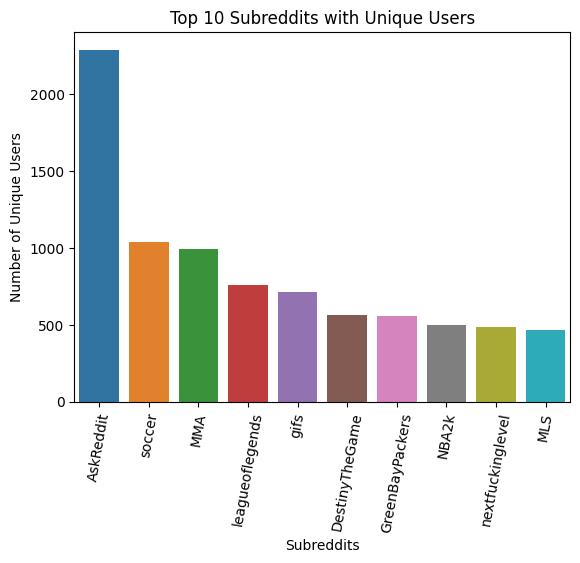

In [4]:
df = users_reddits.groupby(by='bodybuilding').nunique().rename({'------Username------':'count'}, axis=1)[['count']].reset_index().rename({'bodybuilding':'subreddit'})
top_10_subs = df.sort_values('count', ascending=False).head(10)


sns.barplot(data=top_10_subs, x="bodybuilding", y="count")
plt.xticks(rotation=80)
plt.title('Top 10 Subreddits with Unique Users')
plt.xlabel('Subreddits')
plt.ylabel('Number of Unique Users')
plt.show()

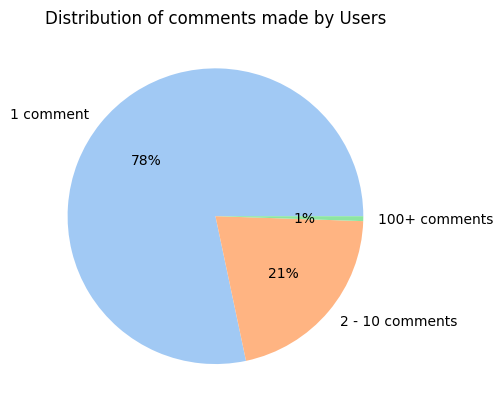

In [5]:
users_cmt_cnt = users_cmts.groupby('------Username------').nunique().reset_index().rename({'------Username------':'usernames', 'e5uz9c6':'num_cmts'}, axis=1).sort_values('num_cmts', ascending=False)

def bin(x):
    if x == 1:
        return '1 comment'
    elif 1 < x < 11:
        return '2 - 10 comments'
    elif 11 <= x:
        return '100+ comments'

users_cmt_cnt['range'] = users_cmt_cnt['num_cmts'].apply(bin)
simp = users_cmt_cnt['range'].value_counts(normalize=True).to_frame().reset_index()

data = simp['range']
labels = simp['index']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Distribution of comments made by Users')
plt.show()

In [2]:
user_cmts = dd.read_csv('../new_data/user_comment.csv', header=None)
cmt_cmt = dd.read_csv('../new_data/comment_comment.csv', header=None)
sub_cmt = dd.read_csv('../new_data/subreddit_comment.csv', header=None)

In [4]:
new_columns = ['users', 'cmt_id']
user_cmts = user_cmts.rename(columns=dict(zip(user_cmts.columns, new_columns)))

new_columns = ['cmt_id', 'cmt_1']
cmt_cmt = cmt_cmt.rename(columns=dict(zip(cmt_cmt.columns, new_columns)))

new_columns = ['sub', 'cmt_id']
sub_cmt = sub_cmt.rename(columns=dict(zip(sub_cmt.columns, new_columns)))

In [10]:
sub_cmt_cnts = sub_cmt.groupby('sub').cmt_id.count().to_frame().reset_index().compute()
sub_cmt_cnts